In [1]:
import os
import re
import time

import cv2
import numpy as np
from matplotlib import pyplot as plt

def showimg(image):
    # Displaying the image
    pixel_width = 1655
    pixel_height = 2340
    dpi = 100

    # Calculate figure size in inches becuz matplotlib hates just specifying pixel sizes
    fig_width = pixel_width / dpi
    fig_height = pixel_height / dpi

    # Create the figure and display the image
    fig, ax = plt.subplots(figsize=(fig_width, fig_height), dpi=dpi)
    ax.imshow(image)
    ax.axis('off')  # Turn off the axes for better visualization
    plt.show()

def showcontours(contours, x=2340, y=1655):
    blank_image = np.zeros((x, y, 3), np.uint8)  # blank black img for seeing contours
    img_contours = cv2.drawContours(blank_image, contours, -1, (0, 255, 0), 2)
    showimg(img_contours)



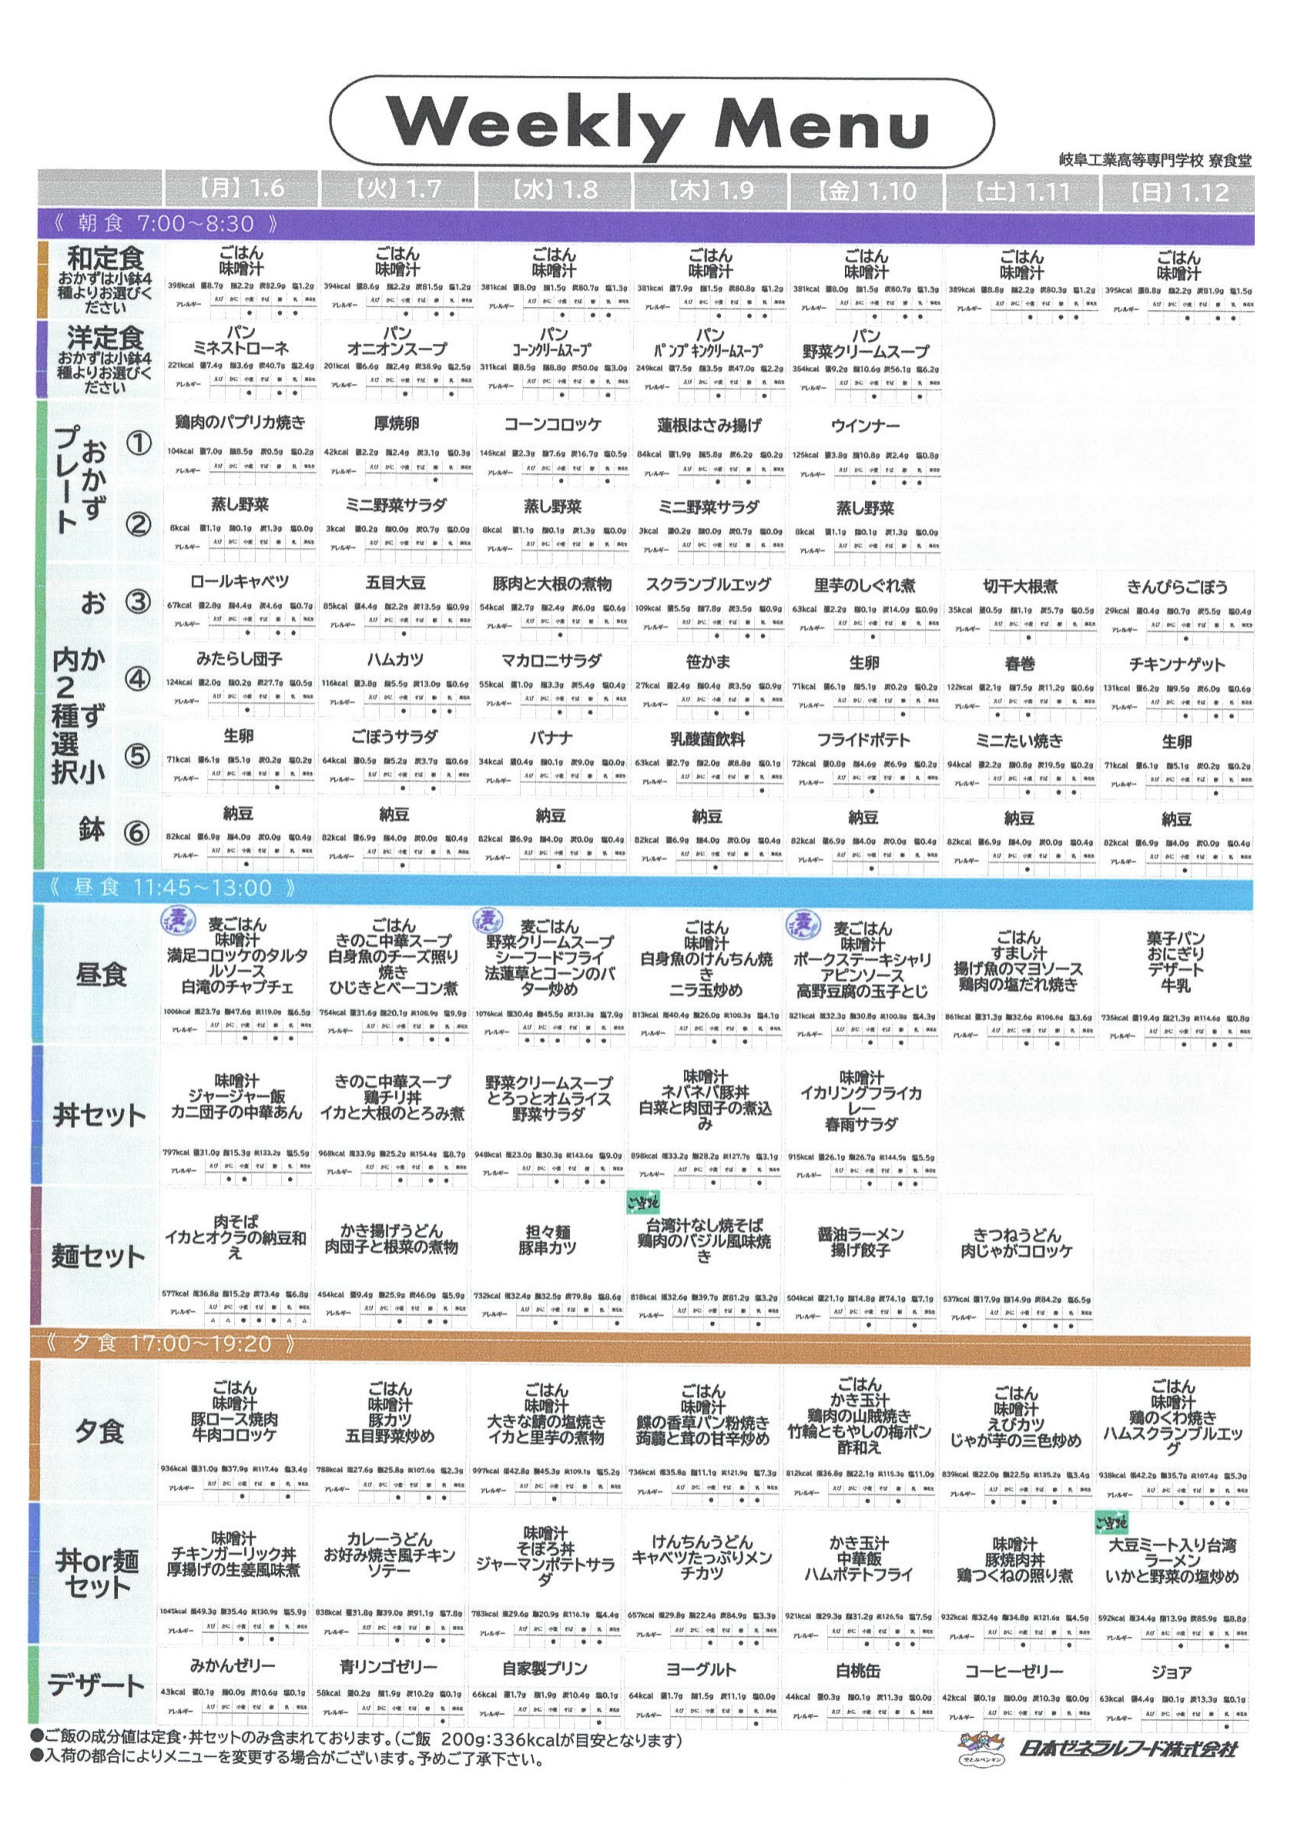

In [2]:
# Load the image
year = "2025"  # variable needed for date check
image_path = f"menus/{year}/2_1_Jan.Pdf-1.png"
image = cv2.imread(image_path)

showimg(image)

# This portion of the code tries to straighten the image


In [3]:
# Convert to grayscale and get the largest contour
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
ret, thresh = cv2.threshold(gray, 251, 255, cv2.THRESH_OTSU)
contours, _ = cv2.findContours(thresh, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
largest_contour = None

# Finding the "Weekly Menu"'s big contour on top
top_contour = [(contour.astype(int)) for contour in contours]
top_contour.reverse()  # contour starts from bottom up, changing to top down
for contour in range(1, len(top_contour)):
    # skip first few cuz it might be a outline of the whole image, literally, print it out
    if cv2.contourArea(top_contour[contour]) > 7000:  # Check contour area
        largest_contour = top_contour[contour]
        # showcontours(largest_contour)
        break

# Get angle for rotation
rect = cv2.minAreaRect(largest_contour)
angle = rect[-1]

# Sometimes angle might be too huge
if angle > 10:
    angle -= 90
elif angle < -10:
    angle += 90

# very hacky
# if angle is still too big, try get angle from largest contour instead
if -1 > angle or angle > 1:
    largest_contour = max(contours, key=cv2.contourArea)
    rect = cv2.minAreaRect(largest_contour)
    angle = rect[-1]

    if angle > 10:
        angle -= 90
    elif angle < -10:
        angle += 90

    if -1 > angle or angle > 1:
        print("this image can't be straightened:", image_path)
        angle = 0  # disables the angle completely

# Rotate the image
(h, w) = image.shape[:2]
center = (w // 2, h // 2)
rotation_matrix = cv2.getRotationMatrix2D(center, angle, 1.0)
straightened = cv2.warpAffine(image, rotation_matrix, (w, h), flags=cv2.INTER_CUBIC,
                              borderMode=cv2.BORDER_REPLICATE)

print("Angle to rotate:", angle)

# showimg(straightened)
# showcontours(contours)


Angle to rotate: 0.320084810256958


In [4]:
# # trying to find what's breaking the "straightened" turns out, using biggest contour to straighten is bad
# # the biggest contour on top (the eclipse) is doable
# contour_index = 0
# blank_image = np.zeros((2340, 1655, 3), np.uint8)
# height, width = blank_image.shape[:2]
# resized_image = cv2.resize(blank_image, (int(width * 0.25), int(height * 0.25)))  # resized down so it fits in my screen
# scaled_contours = [((contour * 0.25).astype(int)) for contour in contours]  # resized down so it fits in my screen
# scaled_contours.reverse()  # contours are bottom up, I want top down (and there's like 50k contours)
# contors = [((contor + 0).astype(int)) for contor in contours]  # 
# contors.reverse()
# 
# while True:
#     # Make another copy to reset for each contour
#     display_image = resized_image.copy()
# 
#     # Draw the current contour
#     cv2.drawContours(display_image, [scaled_contours[contour_index]], -1, (0, 255, 0), 3)
# 
#     # Display the image with the current contour
#     cv2.imshow("Contour Viewer", display_image)
#     cv2.putText(display_image, f"Contour: {contour_index + 1}/{len(contours)}",
#             (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2)
#     contour_area = cv2.contourArea(contors[contour_index])
#     print(f"Contour {contour_index}: Area = {contour_area}")
#     key = cv2.waitKey(0)  # Wait for a key press
# 
#     # Handle key presses
#     if key == ord('n'):  # 'n' to go to the next contour
#         contour_index = (contour_index + 1) % len(contours)  # Cycle through contours
#     elif key == ord('p'):  # 'p' to go to the previous contour
#         contour_index = (contour_index - 1) % len(contours)
#     elif key == ord('q'):  # 'q' to quit
#         break
# 
# cv2.destroyAllWindows()


# Detect the lines/edges of the table

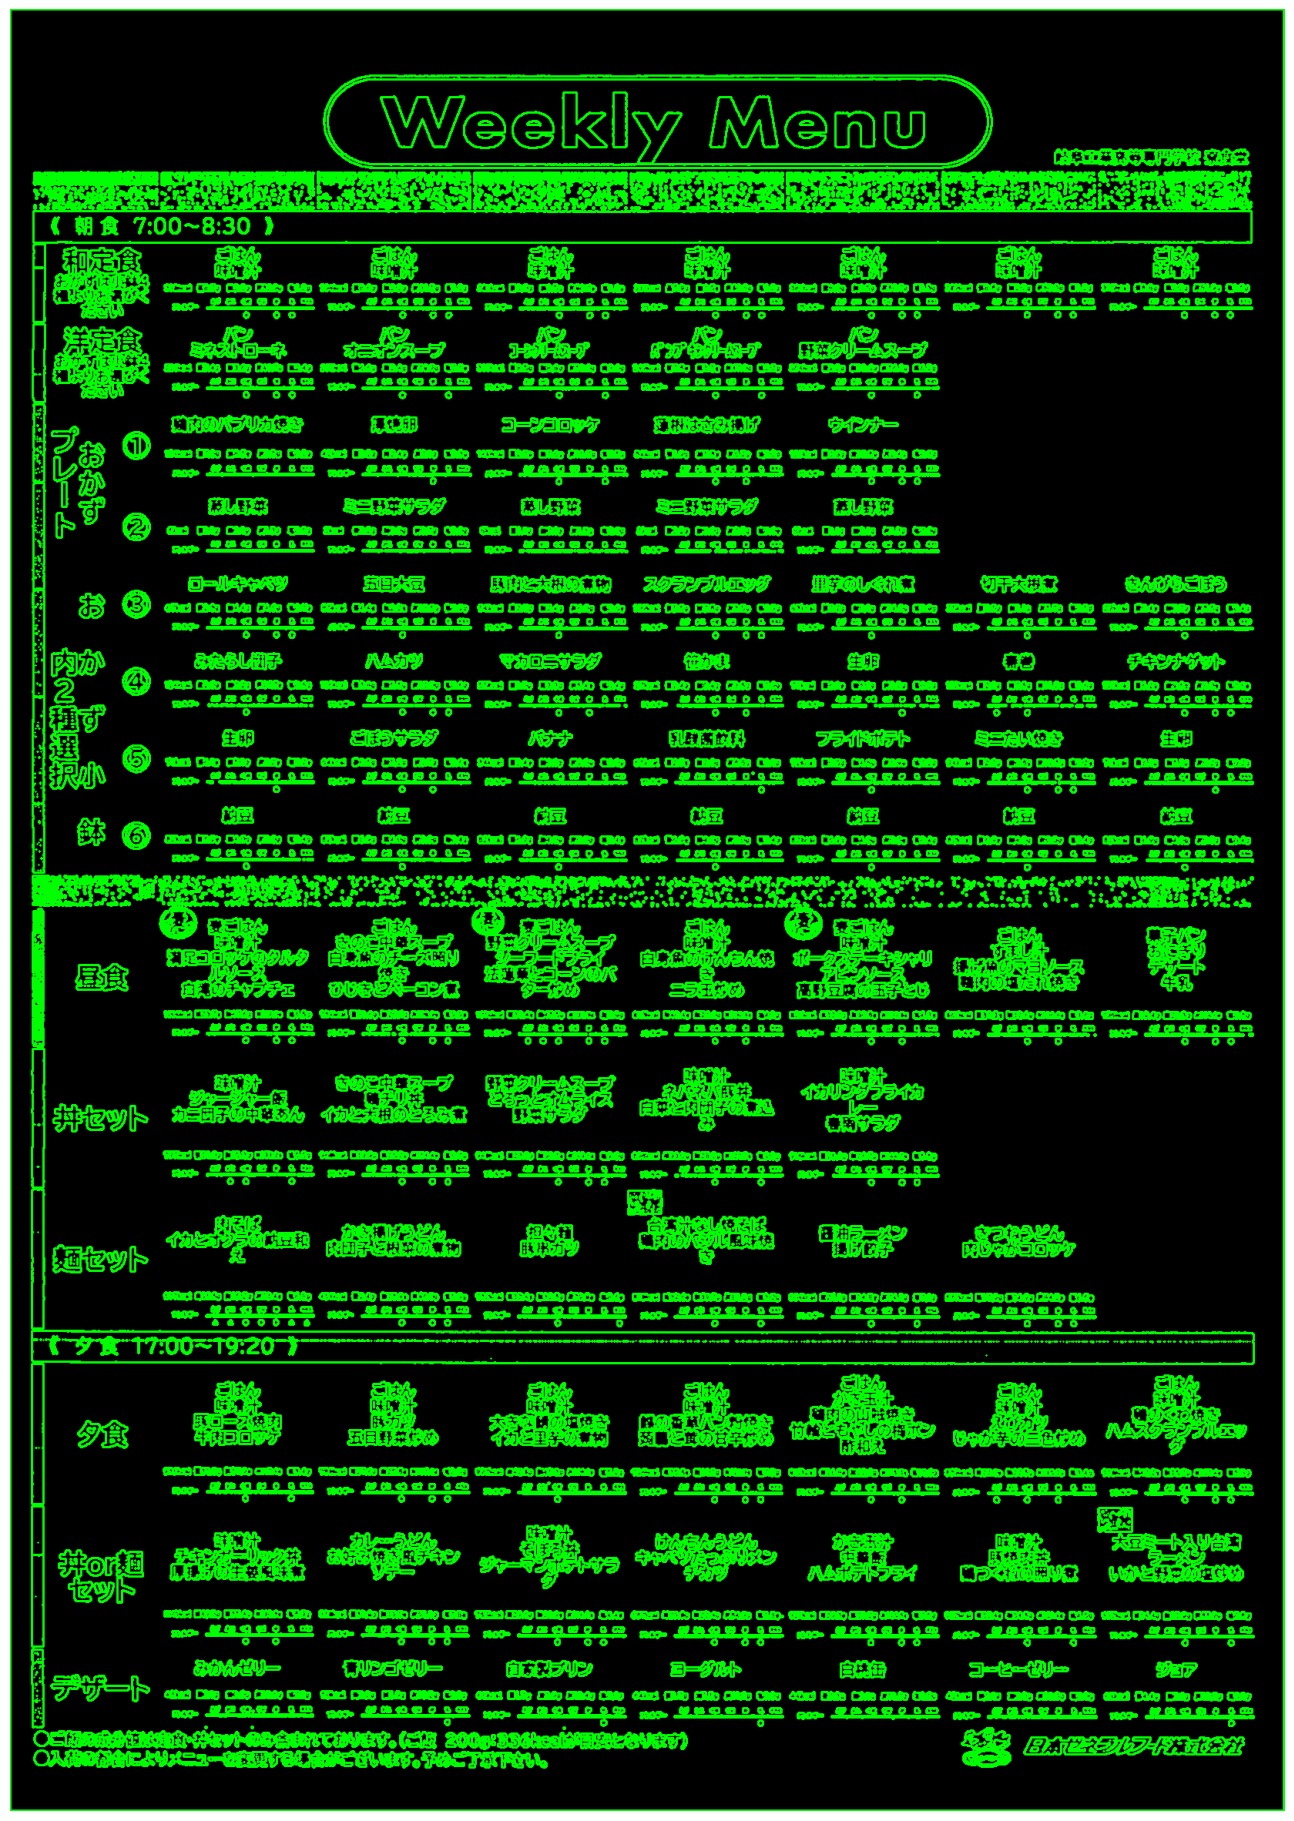

In [5]:
# using otsu to get contours
# TODO: maybe rotate the contours so I don't have to find contours again
straightened_gray = cv2.cvtColor(straightened, cv2.COLOR_BGR2GRAY)
ret, thresh1 = cv2.threshold(straightened_gray, 250, 255, cv2.THRESH_OTSU)

# draw contours on a black background  
blank_image = np.zeros((2340, 1655, 3), np.uint8)  # blank black img for seeing contours
contours, hierarchy = cv2.findContours(thresh1, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
img_contours = cv2.drawContours(blank_image, contours, -1, (0, 255, 0), 2)

showimg(img_contours)


## Scans a certain area of the image. It goes through the headers (such as the dates part or type of meals part) and finds the lines, and add their coordinates into the list

In [6]:
xarr = []
yarr = []

In [7]:
# goes through the x-axis
for i in range(5, img_contours.shape[1]):  # start at 5 cuz first few is a outline of the whole image, idk why
    # print(img_contours[i][100][1])
    sum = 0
    for j in range(220, 250):
        sum += img_contours[j][i][1] / 255
    # print(i, sum)  # i = pixel, sum = amount of countour pixels (detected lines)

    if sum > 3:  # filter for vertical line
        xarr.append(i)
        xdiff = [164, 365, 567, 770, 972, 1175, 1377, 1579]
        xarr += [j + i for j in xdiff]
        break
        

In [8]:
# goes through the y-axis
for i in range(5, img_contours.shape[0]):
    # print(img_contours[i][100][1])
    sum = 0
    for j in range(50, 181):
        sum += img_contours[i][j][1] / 255
    # print(i, sum)

    if sum > 30:  # filter for horizontal line
        yarr.append(i)
        ydiff = [50, 92, 197, 301, 413, 513, 613, 713, 813, 913, 956, 1139, 1322, 1506, 1548, 1734, 1920, 2024]
        yarr += [j + i for j in ydiff]
        break
        

# Splitting dishes into their own cells

In [9]:
# # To show how the image is being cut
# # draw on img
# final_image = straightened.copy()
# for i in xarr:
#     cv2.line(final_image, [i, 0], [i, 2340], (0, 255, 0), 1)
# for i in yarr:
#     cv2.line(final_image, [0, i], [1655, i], (0, 255, 0), 1)
# 
# # printing lines on image
# showimg(final_image)

In [10]:
from PIL import Image

def cv2pil(image):
    """ OpenCV型 -> PIL型 """
    new_image = image.copy()
    if new_image.ndim == 2:  # モノクロ
        pass
    elif new_image.shape[2] == 3:  # カラー
        new_image = cv2.cvtColor(new_image, cv2.COLOR_BGR2RGB)
    elif new_image.shape[2] == 4:  # 透過
        new_image = cv2.cvtColor(new_image, cv2.COLOR_BGRA2RGBA)
    new_image = Image.fromarray(new_image)
    return new_image


In [11]:
# import pyocr
# 
# tools = pyocr.get_available_tools()
# if len(tools) == 0:
#     print("OCRツールが見つかりませんでした")
# print(tools)
# tool = tools[0]
# print("use tool :", tool.get_name())
# langs = tool.get_available_languages()
# print(langs)
# 
# crop = straightened[yarr[15]:yarr[16], xarr[3]:xarr[4]]
# 
# # Otsu threshold
# crop_gray = cv2.cvtColor(crop, cv2.COLOR_BGR2GRAY)
# ret2, otsu = cv2.threshold(crop_gray, 0, 255, cv2.THRESH_OTSU)
# otsu_pil = cv2pil(otsu)
# 
# 
# showimg(otsu_pil)  # display image
# txt = tool.image_to_string(otsu_pil, lang='jpn')
# print(txt)

In [12]:
# import easyocr
# reader = easyocr.Reader(['ja']) # this needs to run only once to load the model into memory
# crop = straightened[yarr[15]:yarr[16], xarr[5]:xarr[6]]
# # cv2.imwrite("cropped2.png", crop)
# result = reader.readtext(crop, detail=0)
# print(result)

In [13]:
import easyocr

# easy ocr
reader = easyocr.Reader(['ja'])

## Functions for splitting the image further and OCR

In [14]:
# to prevent cluttering the OCR def, made these functions
def cleanimg(img, brightness_threshold=221):
    # cropping and thresholding
    threshold = 20  # for grayscale like pixels, (if RGB is same of similar enough to each other, keep it)
    
    # Convert the image to float for precise calculations
    image_float = img.astype(np.float32)
    
    # Calculate the absolute differences between R, G, and B channels
    diff_rg = np.abs(image_float[:, :, 2] - image_float[:, :, 1])  # Difference between R and G
    diff_rb = np.abs(image_float[:, :, 2] - image_float[:, :, 0])  # Difference between R and B
    diff_gb = np.abs(image_float[:, :, 1] - image_float[:, :, 0])  # Difference between G and B
    
    # Creating mask for grayscale-like pixels
    grayscale_mask = (
        (diff_rg < threshold) &  # pixel is grayscale-like
        (diff_rb < threshold) & 
        (diff_gb < threshold) &
        (image_float[:, :, 0] < brightness_threshold) &  # RGB below brightness thresh
        (image_float[:, :, 1] < brightness_threshold) &
        (image_float[:, :, 2] < brightness_threshold) 
    )

    cleaned = np.ones_like(img) * 255  # White image
    cleaned[grayscale_mask] = img[grayscale_mask]  # add mask to white img
    return cleaned

def splitdish(img):  # split crop image into 3, dish name, cal and stuff, allergies
    # getting contours of img
    gray_crop = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, thresh1 = cv2.threshold(gray_crop, 250, 255, cv2.THRESH_OTSU)
    
    threshold1 = 50  # affects... ???
    threshold2 = 150  # affects... ???
    edges = cv2.Canny(thresh1, threshold1, threshold2)

    blank_image = np.zeros((img.shape[0], img.shape[1], 3), np.uint8)  # blank black img for seeing contours
    crop_contours, hierarchy = cv2.findContours(edges, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
    crop_contours_img = cv2.drawContours(blank_image, crop_contours, -1, (0, 255, 0), 2)
    
    number_top = 0
    number_bottom = 0
    # looping through to find area to split
    for i in range(img.shape[0]-1, -1, -1):  # -1 to loop from bottom of img to up
        sum = 0
        for j in range(0, img.shape[1]):
            sum += crop_contours_img[i][j][1] / 255  # going row by row
            
        if sum > 105:
            number_top = i-36  # since allergy keeps getting detected, use -36 and -22 to get the nutrition coords
            # cv2.line(cleaned, (0, i-22), (202, i-22), (0, 255, 0))  # line below numbers
            number_bottom = i-22
            break
    return number_top, number_bottom

def splitnutrition(img):
    xcut = []
    for j in range(img.shape[1]-1, -1, -1):
        check = True
        for i in range(img.shape[0]):
            if img[i][j][1] != 255:
                check = False
                break
        if check:
            xcut.append(j)

    # another loop with funni logic that works, could be better
    # if list is [201, 200, 193, 170, 169, 168, 167, 166, 165, 164, 163, 139, 127, 126, 125, 124, 103, 88, 87, 86, 85, 84, 48, 47, 46, 45, 44, 8, 7, 6, 4, 3, 2, 1]
    # we are trying to rule out the weird 103, 139, 170, 193, 200, 201, by checking if there's at least 3 consecutive columns of white
    numbers = sorted(set(xcut))  # Sort in ascending order and remove duplicates if any
    xcut = []

    i = 0
    while i < len(numbers):
        group = [numbers[i]]
    
        # Find consecutive sequences
        while i + 1 < len(numbers) and numbers[i] + 1 == numbers[i + 1]:
            group.append(numbers[i + 1])
            i += 1
    
        # If the group has 3 or more consecutive numbers, keep only the median
        if len(group) >= 3:
            median_value = group[len(group) // 2]  # Find median whole number
            if median_value >= 5:  # Keep only numbers >= 30
                xcut.append(median_value)
                
        i += 1
    
    # adding another line for the start and end of the lines
    real_cut = xcut
    if xcut[0] > 10:
        real_cut.insert(0, 0)
    if xcut[-1] < (img.shape[1] - 10):
        real_cut.append(img.shape[1]-1)
    
    # finally, splitting the img into their respective nutrients
    kcal_img = img[0:img.shape[0], real_cut[0]:real_cut[1]]
    protein_img = img[0:img.shape[0], real_cut[1]:real_cut[2]]
    fats_img = img[0:img.shape[0], real_cut[2]:real_cut[3]]
    carb_img = img[0:img.shape[0], real_cut[3]:real_cut[4]]
    salt_img = img[0:img.shape[0], real_cut[4]:real_cut[5]]
    
    return kcal_img, protein_img, fats_img, carb_img, salt_img


In [15]:
import pytesseract

def dishOCR(crop):
    # removing very light gray and other noise
    cleaned = cleanimg(crop)  # TODO: maybe can clean the whole image before cropping
    number_top, number_bottom = splitdish(cleaned)  # split crop image into 3, dish name, cal and stuff, allergies
            
    if number_top == 0 and number_bottom == 0:  # if can't detect allergy bar, most likely blank
        return [""], None, None
    
    cleaned_dish_name = cleaned[0:number_top, 0:cleaned.shape[1]]
    cleaned_cal_count = cleaned[number_top:number_bottom, 0:cleaned.shape[1]]
    cleaned_allergy = cleaned[number_bottom:cleaned.shape[0], 0:cleaned.shape[1]]
    
    final_dish_name = [""]
    final_calories = None
    final_allergy = None  # how tf

    final_dish_name = reader.readtext(cleaned_dish_name, detail=0)
    # final_dish_name = "\n".join(final_dish_name)
    
    if final_dish_name == "":  # if no dish name, probably blank
        return [""], None, None

    # TODO: find a better OCR that works with individual images
    # kcal_img, protein_img, fats_img, carb_img, salt_img = splitnutrition(cleaned_cal_count)
    # easyocr = reader.readtext(kcal_img, detail=0, allowlist="0123456789kcal")
    pytess = pytesseract.image_to_string(cleaned_cal_count, config="-c tessedit_char_whitelist=0123456789kcal.")
    final_calories = re.search(r"([0-9]*)k?c?a?l?", pytess)[1]
    
    return final_dish_name, final_calories, final_allergy


In [16]:
# TODO: maybe this for reading numbers idk
def numberOCR(img):
    pass

In [17]:
# # everything below is for testing other image preprocessing
# kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2))
# dilates = cv2.dilate(cleaned, kernel)
# erode = cv2.erode(cleaned, kernel) 
# 
# # Sharpen the image
# kernel = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]]) 
# sharp = cv2.filter2D(cleaned, -1, kernel)
# 
# showimg(crop)
# showimg(cleaned)
# # showimg(dilates)
# # showimg(erode)
# # showimg(sharp)
# 
# text = pytesseract.image_to_string(cleaned, lang="jpn")
# print(text)

In [18]:
# # testing stuff with cropping, cleaning, splitting the crop even more
# crop = straightened[yarr[11]:yarr[12], xarr[4]:xarr[5]]
# cleaned = cleanimg(crop)
# 
# # creating contours for the cleaned crop
# gray_crop = cv2.cvtColor(cleaned, cv2.COLOR_BGR2GRAY)
# ret, thresh1 = cv2.threshold(gray_crop, 250, 255, cv2.THRESH_OTSU)
# 
# threshold1 = 50  # affects... ???
# threshold2 = 150  # affects... ???
# edges = cv2.Canny(thresh1, threshold1, threshold2)
# 
# blank_image = np.zeros((crop.shape[0], crop.shape[1], 3), np.uint8)  # blank black img for seeing contours
# crop_contours, hierarchy = cv2.findContours(edges, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
# crop_contours_img = cv2.drawContours(blank_image, crop_contours, -1, (0, 255, 0), 2)
# 
# 
# # split into dish name, calories and stuff, and allergies
# number_top, number_bottom = splitdish(cleaned)
# 
# # showimg(crop)
# # showimg(cleaned)
# # showimg(crop_contours_img)
# 
# cleaned_dish_name = cleaned[0:number_top, 0:cleaned.shape[1]]
# cleaned_cal_count = cleaned[number_top:number_bottom, 0:cleaned.shape[1]]
# cleaned_allergy = cleaned[number_bottom:cleaned.shape[0], 0:cleaned.shape[1]]
# # showimg(cleaned_dish_name)
# showimg(cleaned_cal_count)
# # showimg(cleaned_allergy)
# 
# kcal_img, protein_img, fats_img, carb_img, salt_img = splitnutrition(cleaned_cal_count)
# 
# showimg(fats_img)

In [28]:
from datetime import datetime, timedelta

def createdb(data, date):
    data.append(
      {
        "date": date,
        "meal_time":
          {
          "breakfast": {
            "japanese": {
              "name": [],
              "allergy": [],
              "calories": ""
            },
            "western": {
              "name": [],
              "allergy": [],
              "calories": ""
            },
            "plate_sides": [
              {
                "name": [],
                "allergy": [],
                "calories": ""
              },
              {
                "name": [],
                "allergy": [],
                "calories": ""
              }
            ],
            "bowl_sides": [
              {
                "name": [],
                "allergy": [],
                "calories": ""
              },
              {
                "name": [],
                "allergy": [],
                "calories": ""
              },
              {
                "name": [],
                "allergy": [],
                "calories": ""
              },
              {
                "name": [],
                "allergy": [],
                "calories": ""
              }
            ]
          },
          "lunch": {
            "lunch_sides": {
              "name": [],
              "allergy": [],
              "calories": ""
            },
            "don_set": {
              "name": [],
              "allergy": [],
              "calories": ""
            },
            "noodle_set": {
              "name": [],
              "allergy": [],
              "calories": ""
            }
          },
          "dinner": {
            "dinner_sides": {
              "name": [],
              "allergy": [],
              "calories": ""
            },
            "don_or_noodle_set": {
              "name": [],
              "allergy": [],
              "calories": ""
            },
            "dessert": {
              "name": [],
              "allergy": [],
              "calories": ""
            }
          }
        }
      }
    )
    
    return data

def correctdates(year, initial_dates):
    corrected_dates = []

    for i in range(len(initial_dates)):
        # month_day = initial_dates[i][3:]  # will break if ocr didn't detect bracket or day
        date = re.search(r"【?.?】?(\d+\.\d+)", initial_dates[i])

        try:
            month_day = datetime.strptime(f"{year}.{date.group(1)}", "%Y.%m.%d")
        except ValueError:  # invalid date
            month_day = ""
        except AttributeError:  # regex found nothing
            month_day = ""

        if month_day != "" and month_day.weekday() != i:
            month_day = ""
        corrected_dates.append(month_day)

    print("before correcting:", corrected_dates)

    for i in range(len(corrected_dates)):
        if corrected_dates[i] != "":
            if i == 0:
                for j in range(1, 7):
                    corrected_dates[j] = corrected_dates[i] + timedelta(days=j)
            elif i == 6:
                for j in range(5, -1, -1):
                    corrected_dates[j] = corrected_dates[i] - timedelta(days=abs(j-6))
            else:
                for j in range(i+1, 7):
                    corrected_dates[j] = corrected_dates[i] + timedelta(days=j-i)

                for j in range(i-1, -1, -1):
                    corrected_dates[j] = corrected_dates[i] - timedelta(days=abs(j-i))
            break

    print("after correcting:", corrected_dates)
    return [x.strftime("%Y-%m-%d") for x in corrected_dates]


In [33]:
# getting the coords for each box
# range: start from 1 to ignore row header, -1 at the end cuz each box starts counting from top left
import re
# from PIL import ImageDraw, ImageFont
# 
# ocr_image = straightened.copy()
# fontpath = 'meiryo.ttf'  # Windows10 だと C:\Windows\Fonts\ 以下にフォントがあります。
# font = ImageFont.truetype(fontpath)  # フォントサイズが32
# img_pil = Image.fromarray(ocr_image)
# white = np.ones((image.shape[0], image.shape[1], image.shape[2]), np.uint8)
# white.fill(255)
# 
# for i in xarr:
#     cv2.line(white, [i, yarr[0]], [i, yarr[-1]], (0, 255, 0), 1)
# for i in yarr:
#     cv2.line(white, [xarr[0], i], [xarr[-1], i], (0, 255, 0), 1)
# 
# img_pil = Image.fromarray(white)

data = []
result_date = []
for i in range(1, len(xarr)-1):
    date_crop = straightened[yarr[0]:yarr[1], xarr[i]:xarr[i+1]]
    date = cleanimg(date_crop, 250)

    try:
        date = cv2.cvtColor(date, cv2.COLOR_BGR2GRAY)
        ret, date = cv2.threshold(date, 250, 255, cv2.THRESH_OTSU)
        # removing bar and weird specks
        contours, _ = cv2.findContours(date, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

        height, width, _ = date_crop.shape
        min_area = 10  # Remove tiny specks
        max_width_ratio = 0.9  # If a contour is >10% of width, it's a sidebar
        for cnt in contours:
            x, y, w, h = cv2.boundingRect(cnt)
            area = cv2.contourArea(cnt)

            # Remove large vertical side bars
            if w > width * max_width_ratio:
                cv2.drawContours(date, [cnt], -1, (0, 0, 0), thickness=cv2.LINE_4)

            # Remove small random noise
            if area < min_area:
                cv2.drawContours(date, [cnt], -1, (0, 0, 0), thickness=cv2.LINE_4)
    except Exception as e:
        showimg(date)
        print(e)
    result_date += reader.readtext(date, allowlist=r'0123456789.【】月火水木金土日', detail=0)  # returns a list, so += instead of append

# Check correctness of dates
dates = correctdates(year, result_date)
    
for date in dates:
    data = createdb(data, date)


before correcting: [datetime.datetime(2025, 1, 6, 0, 0), datetime.datetime(2025, 1, 7, 0, 0), datetime.datetime(2025, 1, 8, 0, 0), datetime.datetime(2025, 1, 9, 0, 0), '', '', datetime.datetime(2025, 1, 12, 0, 0)]
after correcting: [datetime.datetime(2025, 1, 6, 0, 0), datetime.datetime(2025, 1, 7, 0, 0), datetime.datetime(2025, 1, 8, 0, 0), datetime.datetime(2025, 1, 9, 0, 0), datetime.datetime(2025, 1, 10, 0, 0), datetime.datetime(2025, 1, 11, 0, 0), datetime.datetime(2025, 1, 12, 0, 0)]
[{'date': '2025-01-06', 'meal_time': {'breakfast': {'japanese': {'name': [], 'allergy': [], 'calories': ''}, 'western': {'name': [], 'allergy': [], 'calories': ''}, 'plate_sides': [{'name': [], 'allergy': [], 'calories': ''}, {'name': [], 'allergy': [], 'calories': ''}], 'bowl_sides': [{'name': [], 'allergy': [], 'calories': ''}, {'name': [], 'allergy': [], 'calories': ''}, {'name': [], 'allergy': [], 'calories': ''}, {'name': [], 'allergy': [], 'calories': ''}]}, 'lunch': {'lunch_sides': {'name': []

In [21]:
# # ## testing tesseract and easyocr for reading dates
# import pytesseract  # pyocr doesn't support config??? wth went wrong here???
# crop = straightened[yarr[2]:yarr[3], xarr[1]:xarr[2]]
# 
# gray_crop = cv2.cvtColor(crop, cv2.COLOR_BGR2GRAY)
# ret, date = cv2.threshold(gray_crop, 250, 255, cv2.THRESH_OTSU)
# 
# # removing bar and weird specks
# contours, _ = cv2.findContours(date, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
# height, width, _ = crop.shape
# min_area = 10  # Remove tiny specks
# max_width_ratio = 0.9  # If a contour is >10% of width, it's a sidebar
# 
# for cnt in contours:
#     x, y, w, h = cv2.boundingRect(cnt)
#     area = cv2.contourArea(cnt)
# 
#     # Remove large vertical side bars
#     if w > width * max_width_ratio:
#         cv2.drawContours(date, [cnt], -1, (0, 0, 0), thickness=cv2.FILLED)
#     # Remove small random noise
#     if area < min_area:
#         cv2.drawContours(date, [cnt], -1, (0, 0, 0), thickness=cv2.FILLED)
# 
# showimg(crop)
# showimg(date)
# 
# reader = easyocr.Reader(['ja'])
# print(reader.readtext(date, allowlist=r'0123456789.【】月火水木金土日', detail=0))
# date = Image.fromarray(date)
# print(pytesseract.image_to_string(date, config='-c tessedit_char_whitelist=0123456789.【】月火水木金土日'))
# # 
# # ## easyocr is perfect (after preprocessing). tesseract could use some work around. 
# # # ## It won't read the bracket and day, just the numbers, which is nice. 
# # ## but sometimes, it reads 水 as 0, or 日 as 8. which is easily fixable with a bit of checking for valid dates (we have 12 months not 81)
# # ## and removing the zero at the front to keep everything predictable, but I think i'll go for easyocr either ways
# # ## because import pytesseract requires me to download pytesseract separately

In [22]:
# from PIL import Image
# # testing OCR on calories
# for x in range(1, len(xarr)-1):  # vertical lines
#     for y in range(2, len(yarr)-1):  # horizontal lines
#         # ignore time header
#         if y in [10, 14]:
#             continue
#         crop = straightened[yarr[y]:yarr[y+1], xarr[x]:xarr[x+1]]
#         img = cleanimg(crop)
#         number_top, number_bottom = splitdish(img)
#         
#         if number_top == 0 and number_bottom == 0:
#             continue
#         
#         # TODO: can try what we did with the dates, remove small specks
#         cal = img[number_top:number_bottom, 0:img.shape[1]]
# 
#         # when the image is larger, somehow the OCR works better
#         easyocr = reader.readtext(cal, detail=0, allowlist="0123456789kcal.")
#         pytess = pytesseract.image_to_string(cal, config="-c tessedit_char_whitelist=0123456789kcal.")
#         tess_result = re.search(r"([0-9]*)[k]?[c]?[a]?[l]?", pytess)[1]
#         print(easyocr)
#         print(pytess)
#         print(tess_result)
#         showimg(cal)
# 
#         # when split into smaller images, OCR becomes worse
#         # kcal_img, protein_img, fats_img, carb_img, salt_img = splitnutrition(cal)
#         # kcal_img = cv2pil(kcal_img)
#         # new_size = (kcal_img.width * 2, kcal_img.height * 2)
#         # kcal_img = kcal_img.resize(new_size, Image.Resampling.LANCZOS)
#         # kcal_img = np.array(kcal_img)
#         # kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2))
#         # kcal_img = cv2.dilate(kcal_img, kernel)
#         # print(reader.readtext(kcal_img, detail=0, allowlist="0123456789kcal."))
#         # print(pytesseract.image_to_string(kcal_img, config="-c tessedit_char_whitelist=0123456789kcal."))
#         # showimg(kcal_img)
#         

In [34]:
def insert_to_dict(dict, dish_name: list, cal: int, allergies: list):
    for dish in dish_name:
        dict["name"].append(dish)

    if allergies is not None:
        for allergy in allergies:
            dict["allergy"].append(allergy)
        
    if cal is None:
        dict["calories"] = ""
    else:
        dict["calories"] = cal
    
    return dict
    

# looping through all dishes
for x in range(1, len(xarr)-1):  # vertical lines
    current = data[x-1]["meal_time"]
    for y in range(2, len(yarr)-1):  # horizontal lines
        # ignore time header
        if y in [10, 14]:
            continue
        
        # crop img, OCR for text
        crop = straightened[yarr[y]:yarr[y+1], xarr[x]:xarr[x+1]]   # i don't know why it's [y, x] not [x, y]
        dish_name, calories, allergy = dishOCR(crop)
        
        match y:
            case 2:
                insert_to_dict(current["breakfast"]["japanese"], dish_name, calories, allergy)
            case 3:
                insert_to_dict(current["breakfast"]["western"], dish_name, calories, allergy)
            case 4 | 5:
                insert_to_dict(current["breakfast"]["plate_sides"][y-4], dish_name, calories, allergy)
            case 6 | 7 | 8 | 9:
                insert_to_dict(current["breakfast"]["bowl_sides"][y-6], dish_name, calories, allergy)
            case 11:
                insert_to_dict(current["lunch"]["lunch_sides"], dish_name, calories, allergy)
            case 12:
                insert_to_dict(current["lunch"]["don_set"], dish_name, calories, allergy)
            case 13:
                insert_to_dict(current["lunch"]["noodle_set"], dish_name, calories, allergy)
            case 15:
                insert_to_dict(current["dinner"]["dinner_sides"], dish_name, calories, allergy)
            case 16:
                insert_to_dict(current["dinner"]["don_or_noodle_set"], dish_name, calories, allergy)
            case 17:
                insert_to_dict(current["dinner"]["dessert"], dish_name, calories, allergy)

print(data)
            
        
# # for writing out to an image
#         text = ""
#         if type(dish_name) == list:
#             tmp = ""
#             for line in dish_name:
#                 tmp += line + "\n"
#             text = tmp
# 
# 
#         ## displaying the text that OCR found
#         # cv2 isn't compatible with japanese, leaving this in here for my info
#         # ocr_image = cv2.putText(ocr_image, text, (xarr[x], yarr[y+1]), font, 1, (0, 0, 0), 1)
#         draw = ImageDraw.Draw(img_pil)
#         dish_name += f"\n{calories}kcal"
#         draw.text((xarr[x], yarr[y]), text, font=font, fill=(0, 0, 0, 0))
# 
# 
# ocr_image = np.array(img_pil)
# cv2.imwrite("ocr-easyocr.png", ocr_image)


[{'date': '2025-01-06', 'meal_time': {'breakfast': {'japanese': {'name': ['ごはん', '味唱汁'], 'allergy': [], 'calories': '3900'}, 'western': {'name': ['パン', 'ミネストローネ'], 'allergy': [], 'calories': '22'}, 'plate_sides': [{'name': ['駒肉のパプリカ焼き'], 'allergy': [], 'calories': '104'}, {'name': ['蒸し野菜'], 'allergy': [], 'calories': '6'}], 'bowl_sides': [{'name': ['ロールキヤベツ'], 'allergy': [], 'calories': '67'}, {'name': ['みたらし岡子'], 'allergy': [], 'calories': '24'}, {'name': ['生卵'], 'allergy': [], 'calories': ''}, {'name': ['納豆'], 'allergy': [], 'calories': '2'}]}, 'lunch': {'lunch_sides': {'name': ['蓑ごはん', '味唱汁', '満足コ別-野タルタ', '白滝のチャプチェ'], 'allergy': [], 'calories': '10023'}, 'don_set': {'name': ['味唱汁', 'ジャージヤー飯', 'カニ団子の中華あん'], 'allergy': [], 'calories': '7197'}, 'noodle_set': {'name': ['肉そば', 'イカとオクラの納豆和', 'え'], 'allergy': [], 'calories': '77'}}, 'dinner': {'dinner_sides': {'name': ['霧', '駒し'], 'allergy': [], 'calories': '936'}, 'don_or_noodle_set': {'name': ['味噌汁', '喬と宝'], 'allergy': [], 'calories': '1

In [35]:
import json

# data = {"name": "日本語テスト"}

# Writing to test.json
with open("output/test.json", "w", encoding="utf8") as f:
    json.dump(data, indent=2, fp=f, ensure_ascii=False)
